In [11]:
import numpy as np

x = np.load(
    r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\res\time_data_1_sec_force_quality_plus_t\x_for_ltsm.npy")
y = np.load(
    r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\res\time_data_1_sec_force_quality_plus_t\y_for_ltsm.npy")

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
SEED = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

signal_x_train = x_train[:, :-1]
signal_x_test = x_test[:, :-1]
temp_x_train = x_train[:, -1].reshape(-1, 1)
temp_x_test = x_test[:, -1].reshape(-1, 1)

sc_temp = StandardScaler()
temp_x_train = sc_temp.fit_transform(temp_x_train)
temp_x_test = sc_temp.transform(temp_x_test)

sc = StandardScaler()
train_shape = signal_x_train.shape

signal_x_train = signal_x_train.reshape(train_shape[0]*train_shape[1])
signal_x_train = sc.fit_transform(signal_x_train.reshape(-1, 1))
signal_x_train = signal_x_train.reshape(train_shape[0], train_shape[1])

test_shape = signal_x_test.shape
signal_x_test = signal_x_test.reshape(test_shape[0]*test_shape[1])
signal_x_test = sc.transform(signal_x_test.reshape(-1, 1))
signal_x_test = signal_x_test.reshape(test_shape[0], test_shape[1])


In [13]:
import tensorflow as tf
from tensorflow import keras

# create and fit the LSTM network it has two inputs, time dataseries and temperature
time_input = keras.layers.Input(shape=(1666, 1))
temp_input = keras.layers.Input(shape=(1,))

lstm = keras.layers.LSTM(64, input_shape=(1666, 1))(time_input)
dense0 = keras.layers.Dense(1, activation="relu")(temp_input)

merged = keras.layers.Concatenate(axis=1)([lstm, dense0])

dense1 = keras.layers.Dense(128, activation="relu")(merged)
drop_out_1 = keras.layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(128, activation="relu")(drop_out_1)
drop_out_2 = keras.layers.Dropout(0.2)(dense2)

output = keras.layers.Dense(13, activation="softmax")(drop_out_2)

model = keras.models.Model(inputs=[time_input, temp_input], outputs=output)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1666, 1)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           16896       ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 1)            2           ['input_4[0][0]']                
                                                                                            

In [14]:
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
)
# Compile the model.
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc")
    ],
)

In [15]:
batch_size = 128
num_epochs = 500

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
# Fit the model.
history = model.fit(
    x=[signal_x_train, temp_x_train],
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=2,
)


Epoch 1/500
1193/1193 - 98s - loss: 2.4559 - acc: 0.2347 - val_loss: 2.4416 - val_acc: 0.2362 - 98s/epoch - 83ms/step
Epoch 2/500
1193/1193 - 95s - loss: 2.4422 - acc: 0.2358 - val_loss: 2.4392 - val_acc: 0.2362 - 95s/epoch - 80ms/step
Epoch 3/500
1193/1193 - 96s - loss: 2.4292 - acc: 0.2345 - val_loss: 2.4247 - val_acc: 0.2362 - 96s/epoch - 80ms/step
Epoch 4/500
1193/1193 - 96s - loss: 2.3442 - acc: 0.2357 - val_loss: 2.2971 - val_acc: 0.2365 - 96s/epoch - 80ms/step
Epoch 5/500
1193/1193 - 96s - loss: 2.3556 - acc: 0.2381 - val_loss: 2.2897 - val_acc: 0.2375 - 96s/epoch - 80ms/step
Epoch 6/500
1193/1193 - 96s - loss: 2.4196 - acc: 0.2366 - val_loss: 2.4153 - val_acc: 0.2411 - 96s/epoch - 80ms/step
Epoch 7/500
1193/1193 - 96s - loss: 2.3498 - acc: 0.2379 - val_loss: 2.3629 - val_acc: 0.2363 - 96s/epoch - 81ms/step
Epoch 8/500
1193/1193 - 96s - loss: 2.3518 - acc: 0.2359 - val_loss: 2.3200 - val_acc: 0.2363 - 96s/epoch - 80ms/step
Epoch 9/500
1193/1193 - 96s - loss: 2.3338 - acc: 0.2387

In [16]:
_, accuracy = model.evaluate([signal_x_test, temp_x_test], y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

1491/1491 [==============================] - 31s 20ms/step - loss: 2.2644 - acc: 0.2455
Test accuracy: 24.55%


Test accuracy: 24.55%


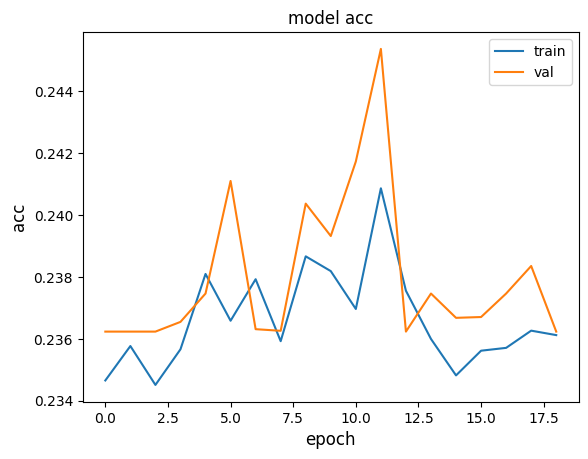

In [17]:
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
import matplotlib.pyplot as plt
metric = "acc"
plt.figure()
plt.plot(history.history[metric], label="train")
plt.plot(history.history["val_" + metric], label="val")
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend()
plt.show()
plt.close()

In [18]:
model.save(r'C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\models\time_all_std_force_quality\LTSM_time.h5', save_format="h5")

1491/1491 [==============================] - 29s 20ms/step


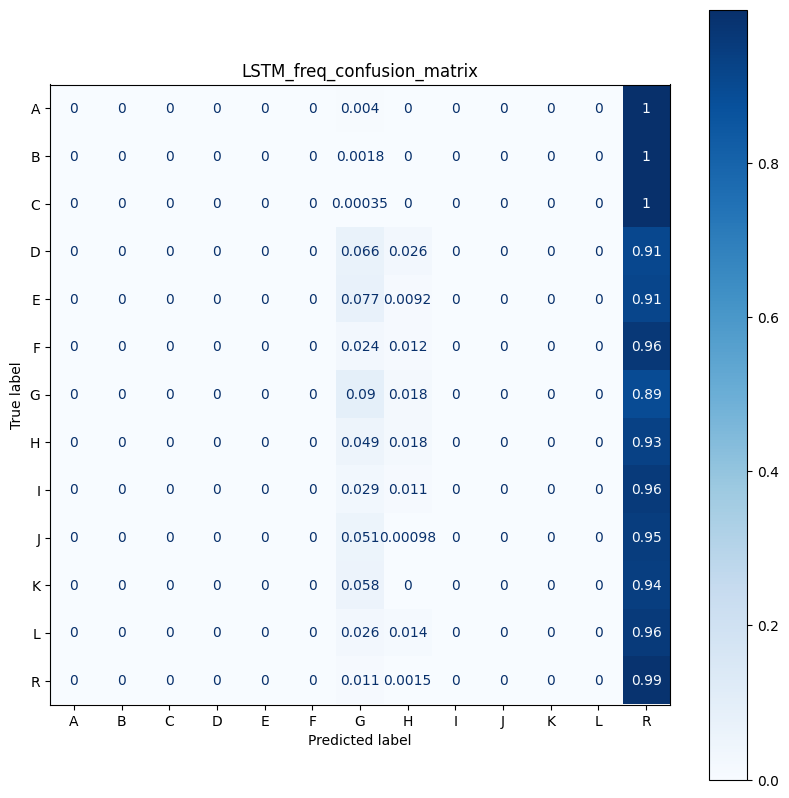

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
y_pred = model.predict([signal_x_test, temp_x_test])
y_pred = np.argmax(y_pred, axis = 1)
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=lb.inverse_transform(range(0, 13)),
    cmap=plt.cm.Blues,
    normalize="true",
    ax=ax
)
disp.ax_.set_title("LSTM_freq_confusion_matrix")

plt.show()